### Plot Functions [X] Temperature Circles 
```
Type: Temperature circle by Antti Lipponen
Panels: One
Animation: Yes
```

***Description:***
- The notbook includes the Python code to make the visualization of the "Temperature circle" adapted from Anti Lipponen 
- The code draws only a single image. The animation code is basically just a loop through the time.

***Notebook includes***
- *The functions to plot the temperature circles.*
- *The fuction to generate and format the data to make the plots*
- *Can also be use to make animations -- examples included*

In [1]:
import os
import ast
import regionmask
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Circle
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

***Fuction to plot the temperature circle***

In [2]:
# This fuction is written by adapting the script from Antti Lipponen from <https://gist.github.com/anttilipp/6b572512ef53cfc6bf949afdc8eb6720>
# The script is not optimized for all anomalous values
# Plot requires values to be in between 3.5 to -4.0

def plot_temperature_cirle(data,tmm='yyyy',figtim='Year',cmap=None,vMin=-3,vMax=3,optnm=None):
    """
    Description:
    The function generates a temperature circle plot based on the provided data, displaying temperature anomalies across different continents and countries. 
    The temperature anomalies are represented using colors from the specified colormap. 
    The function incorporates various visual elements such as text labels, lines, and annotations to create an informative visualization of temperature data.

    Arguments:
    data (dictonary): A dictionary containing temperature data grouped by continents and countries.
                      Use function categorize_countries_by_continents to generate values.
    tmm: str, The year/day being plotted (default is yyyy).
    figtim: str, Figure time name corresponding to the year/day/time being plotted (default is Year)
    cmap: str, A colormap for representing the temperature values (default is None).
    vMin: float, Minimum value for normalization of the colormap (default is -3).
    vMax: float, Maximum value for normalization of the colormap (default is 3).
    optnm: str, Optional name for the output file. If provided, the plot is saved with this name; 
           otherwise, the plot is displayed but not saved.
   
    Returns:
    The function returns a matplotlib plot object, which can be used to display the plot or save it to a file.
    """
    
    # Font and background
    backgroundcolor =  '#ffffff' #'#faf2eb'
    fontname = None #'Lato'
    yearname = tmm # ploting year

    # Fuction to define the circular plot
    def rotText(areaText, defaultspacing, rotangleoffset, rText, fontname):
        angle = areaText[0][1]
        for ii, l in enumerate(areaText):
            if ii > 0:
                angle += defaultspacing + l[1]
            plt.text(
                (rText) * np.sin(np.deg2rad(angle)),
                (rText) * np.cos(np.deg2rad(angle)),
                '{}'.format(l[0]),
                {'ha': 'center', 'va': 'center'},
                rotation=-angle + rotangleoffset,
                fontsize=15,
                fontname=fontname,
            )


    plt.rcParams['axes.facecolor'] = backgroundcolor
    mpl.rcParams.update({'font.size': 22})

    cmap = plt.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=vMin, vmax=vMax)

    Ncountries = 0
    Ncontinents = 0
    for countrylist in data.items():
        Ncountries += len(countrylist[1])
        Ncontinents += 1

    spaceBetweenContinents = 10.0  # 3.0 degrees
    Nspaces = Ncontinents - 1
    anglePerCountry = (345.0 - Nspaces * spaceBetweenContinents) / (Ncountries - 1)


    fig, ax = plt.subplots(figsize=(15, 15))
    renderer = fig.canvas.get_renderer()
    transf = ax.transData.inverted()

    # Adjust to add aditional levels
    # Adjustments to be made across the script if values below are changed 
    limitangles = np.linspace(np.deg2rad(5.0), np.deg2rad(355.0), 500)
    scaleRs = [
        # [1.0, '-5.0', True, 0.25],
        # [1.5, '-5.0', True, 0.25],
        [2.02, '-3.0', True, 0.25],
        [2.4, '-2.0', True, 0.25],
        [2.77, '-1.0', True, 0.25],
        [3.15, '0.0', True, 1.00],
        [3.53, '+1.0', True, 0.25],
        [3.9, '+2.0', True, 0.25],
        [4.27, '+3.0', True, 0.25],
        # [5.0, '+3.0', True, 0.25],
        # [5.5, '+5.0', True, 0.25],
        # [6.0, '+5.0', True, 0.25],
        # [2.0, '$^\\circ$C', False, 0.0]
    ]

    for r in scaleRs:
        if r[2]:
            ax.plot(r[0] * np.sin(limitangles), r[0] * np.cos(limitangles), linewidth=r[3], color='#888888', linestyle='-')
        plt.text(
            0.0,
            r[0],
            '{}'.format(r[1]),
            {'ha': 'center', 'va': 'center'},
            fontsize=12,
            fontname=fontname,
        )


    angle = 7.5
    rText = 5.0  #Plots the country names
    for continent in ['AFRICA', 'ASIA', 'EUROPE', 'AMERICA', 'OCEANIA']:
        for country in data[continent]:

            if angle < 185.0:
                rotangle = -angle + 90.0
            else:
                rotangle = -angle - 90.0

            plt.text(
                (rText) * np.sin(np.deg2rad(angle)),
                (rText) * np.cos(np.deg2rad(angle)),
                '{}'.format(country[0]),
                {'ha': 'center', 'va': 'center'},
                rotation=rotangle,
                fontsize=8,
                fontname=fontname,
                bbox={
                    'facecolor': backgroundcolor,
                    'linestyle': 'solid',
                    'linewidth': 0.0,
                    'boxstyle': 'square,pad=0.0'
                }
            )

            # plot the -- lines
            ax.plot(
                [1.6 * np.sin(np.deg2rad(angle)), 5.0 * np.sin(np.deg2rad(angle))],
                [1.6 * np.cos(np.deg2rad(angle)), 5.0 * np.cos(np.deg2rad(angle))],
                linewidth=0.6,
                linestyle='--',
                color='#DEDEDE'
            )

            lowerRoffset = 0.015
            temperatureAnomaly = country[1]

            # plot bars
            rValue = 2.0 + (temperatureAnomaly + 3.0) / 4.0 * 1.5  # a lot more clever way for computing the radius should be used here...
            ax.plot(
                [(1.6 + lowerRoffset) * np.sin(np.deg2rad(angle)), rValue * np.sin(np.deg2rad(angle))],
                [(1.6 + lowerRoffset) * np.cos(np.deg2rad(angle)), rValue * np.cos(np.deg2rad(angle))],
                linewidth=4.3,
                linestyle='-',
                color='#202020'
            )
            ax.plot(
                [(1.6 + lowerRoffset) * np.sin(np.deg2rad(angle)), rValue * np.sin(np.deg2rad(angle))],
                [(1.6 + lowerRoffset) * np.cos(np.deg2rad(angle)), rValue * np.cos(np.deg2rad(angle))],
                linewidth=4.0,
                linestyle='-',
                color=cmap(norm(temperatureAnomaly))
            )

            angle += anglePerCountry
        angle += spaceBetweenContinents



    c = Circle((0.0, 0.0), radius=1.3, fill=True, color='#fff9f5')
    ax.add_patch(c)
    plt.text(
        0.0,
        -0.52,
        yearname,
        {'ha': 'center', 'va': 'bottom'},
        fontsize=40,
        fontname=fontname,
    )
    plt.text(
        0.0,
        0.27,
        figtim,
        {'ha': 'center', 'va': 'center'},
        fontsize=26,
        fontname=fontname,
    )

    angles = np.linspace(np.deg2rad(0.0), np.deg2rad(360.0), 1000)
    rs = [1.3, 1.6] #name cirle
    for r in rs:
        ax.plot(r * np.sin(angles), r * np.cos(angles), linewidth=1.0, color='#666666', linestyle='-')

    #main title
    plt.title('Global Temperature Anomalies', fontsize=20, loc='center', pad=50)


    # name of continents
    areaText = [
        ['A', 30.0],
        ['f', 0.3],
        ['r', -0.05],
        ['i', -0.15],
        ['c', -0.15],
        ['a', 0.2],
    ]
    rText, defaultspacing, rotangleoffset = 1.43, 4.4, 0.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    areaText = [
        ['E', 210.0],
        ['u', 0.0],
        ['r', 0.3],
        ['o', 0.7],
        ['p', 0.0],
        ['e', 0.0],
    ]
    rText, defaultspacing, rotangleoffset = 1.455, -5.5, 180.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    areaText = [
        ['A', 130.0],
        ['s', -0.8],
        ['i', 0.0],
        ['a', 0.0],
    ]
    rText, defaultspacing, rotangleoffset = 1.455, -4.7, 180.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    areaText = [
        ['A', 260.0],
        ['m', 2.5],
        ['e', 0.6],
        ['r', -0.15],
        ['i', -2.0],
        ['c', -2.0],
        ['a', -0.15],
    ]
    rText, defaultspacing, rotangleoffset = 1.43, 5.85, 0.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    areaText = [
        ['O', 322.5],
        ['c', 1.0],
        ['e', 0.0],
        ['a', 0.2],
        ['n', 0.2],
        ['i', -0.3],
        ['a', -0.3],
    ]
    rText, defaultspacing, rotangleoffset = 1.425, 4.8, 0.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    ax.set_xlim([-5.0, 5.0])
    ax.set_ylim([-5.0, 5.0])
    plt.axis('off')
        
    if optnm:
        plt.savefig(optnm, bbox_inches='tight', format='png',facecolor=backgroundcolor, edgecolor='none', dpi=160)

    # Return the plot
    return plt

***Function to generate the temperature anomalie values***

In [3]:
def categorize_countries_by_continents(tas, lon, lat, glbmn):
    """
    Categorizes countries based on their continents and calculates mean values of a given data array.

    Args:
    tas (array): Temperature data array.
    lon (array): Array of longitudes corresponding to the temperature data.
    lat (array): Array of latitudes corresponding to the temperature data.
    glbnm (array) : Global mean values

    Returns:
    dict: A dictonary containing the categorized countries by continents along with their mean values.
    """
    # Get the continent information for each country
    countries = regionmask.defined_regions.natural_earth_v4_1_0.countries_50
    countriesmask = countries.mask(lon, lat)

    # Create lists for each continent
    continent_countries = {
        'NAMER': [],  # North and South America
        'AS': [],  # Asia
        'EU': [],  # Europe
        'AF': [],  # Africa
        'OC': [],  # Oceania
        # 'AN': []   # Antarctica
    }

    # Full names of continents for printing
    continent_countries_full = {
        'NAMER': 'AMERICA',
        'AS': 'ASIA',
        'EU': 'EUROPE',
        'AF': 'AFRICA',
        'OC': 'OCEANIA',
        # 'AN': 'ANTARCTICA'
    }

    # Categorize countries by continents and calculate mean values
    for i, j in enumerate(countries.abbrevs):
        
        nm = countries.names[i]
        mask = countriesmask == i
        
        Dcn = tas.where(mask)
        Cmn = glbmn.where(mask)
        Can = (Dcn - Cmn)/Cmn
        mn = (Can.mean(dim=['lat','lon']))*100       # just a sample way of anomaly calculation; need to be improved with region mask and climatology       
        mn = mn.where(~((mn > 3.5) | (mn < -4)), 0.0)  # need to fix this, the current plot gives an error if the values are less than -4.0

        try:
            country_alpha_2 = country_name_to_country_alpha2(nm)
            if nm == 'Antarctica':
                continent_code = 'OC'  # Assign 'AN' directly if the country is Antarctica
            else:
                continent_code = country_alpha2_to_continent_code(country_alpha_2)
                if continent_code in ('NA', 'SA'):
                    continent_code = 'NAMER'  # Merge North and South America
            continent_name = continent_code
        except KeyError:
            continent_name = 'nan'

        # Append the country and mean value to the respective continent list
        if not np.isnan(mn.values.item()):
            if continent_code in continent_countries:
                continent_countries[continent_code].append([nm, mn.values.item()])

    # Return the list of countries arranged by continents
    result = "data={\n"
    for continent_code, countries_list in continent_countries.items():
        full = "'"+continent_countries_full[continent_code]+"'"
        result += f"{full}:\n[\n"
        for country in countries_list:
            result += f"\t{str(country)},\n"
        result += '\n],\n'
    result += "}"
    
    result = result.lstrip("data=")
    result_dict = ast.literal_eval(result)

    return result_dict

#### Testing functions

In [4]:
# Load data
t2mfile = "/work/bm1378/a270229/nudge_files/testruns/LUMI_runs/tco1279l137/test/2t.nc"
ds = xr.open_dataset(t2mfile)
tmp = ds['2t']
tas = tmp #.isel(lon=slice(0, -1, 20), lat=slice(1, -1, 20))

# Calculate climatology and anomaly
climatology = tas.mean(dim='time')
#anomaly = ((tas - climatology)/climatology)*100

***Generate data to plot***

In [5]:
lon = tas.lon  # Your longitude data
lat = tas.lat  # Your latitude data
dat = tas[50]  # Your 'tas' array data
result = categorize_countries_by_continents(dat, lon, lat, climatology)
result

{'AMERICA': [['Venezuela', -0.25845521595329046],
  ['Uruguay', 1.398430299013853],
  ['Puerto Rico', -0.6889078300446272],
  ['United States of America', -1.7574002966284752],
  ['S. Geo. and the Is.', 0.7112808059900999],
  ['Br. Indian Ocean Ter.', 0.0019721985154319555],
  ['Saint Helena', 0.25178531650453806],
  ['Pitcairn Is.', 0.8902536705136299],
  ['Anguilla', -0.3615355584770441],
  ['Falkland Is.', 0.3028607461601496],
  ['Cayman Is.', -0.17226990312337875],
  ['Bermuda', -0.9756585583090782],
  ['British Virgin Is.', -0.7163126487284899],
  ['Turks and Caicos Is.', -0.3458876861259341],
  ['Montserrat', -0.11074485955759883],
  ['Trinidad and Tobago', -0.41242316365242004],
  ['Suriname', -0.3744585905224085],
  ['S. Sudan', 0.06200663046911359],
  ['Saint Lucia', -0.22557389456778765],
  ['St. Kitts and Nevis', -0.21222899667918682],
  ['Peru', 0.42158225551247597],
  ['Paraguay', 0.5464816465973854],
  ['Panama', -0.16995787154883146],
  ['Nicaragua', -0.36221928894519806

***Plots temperature circle***

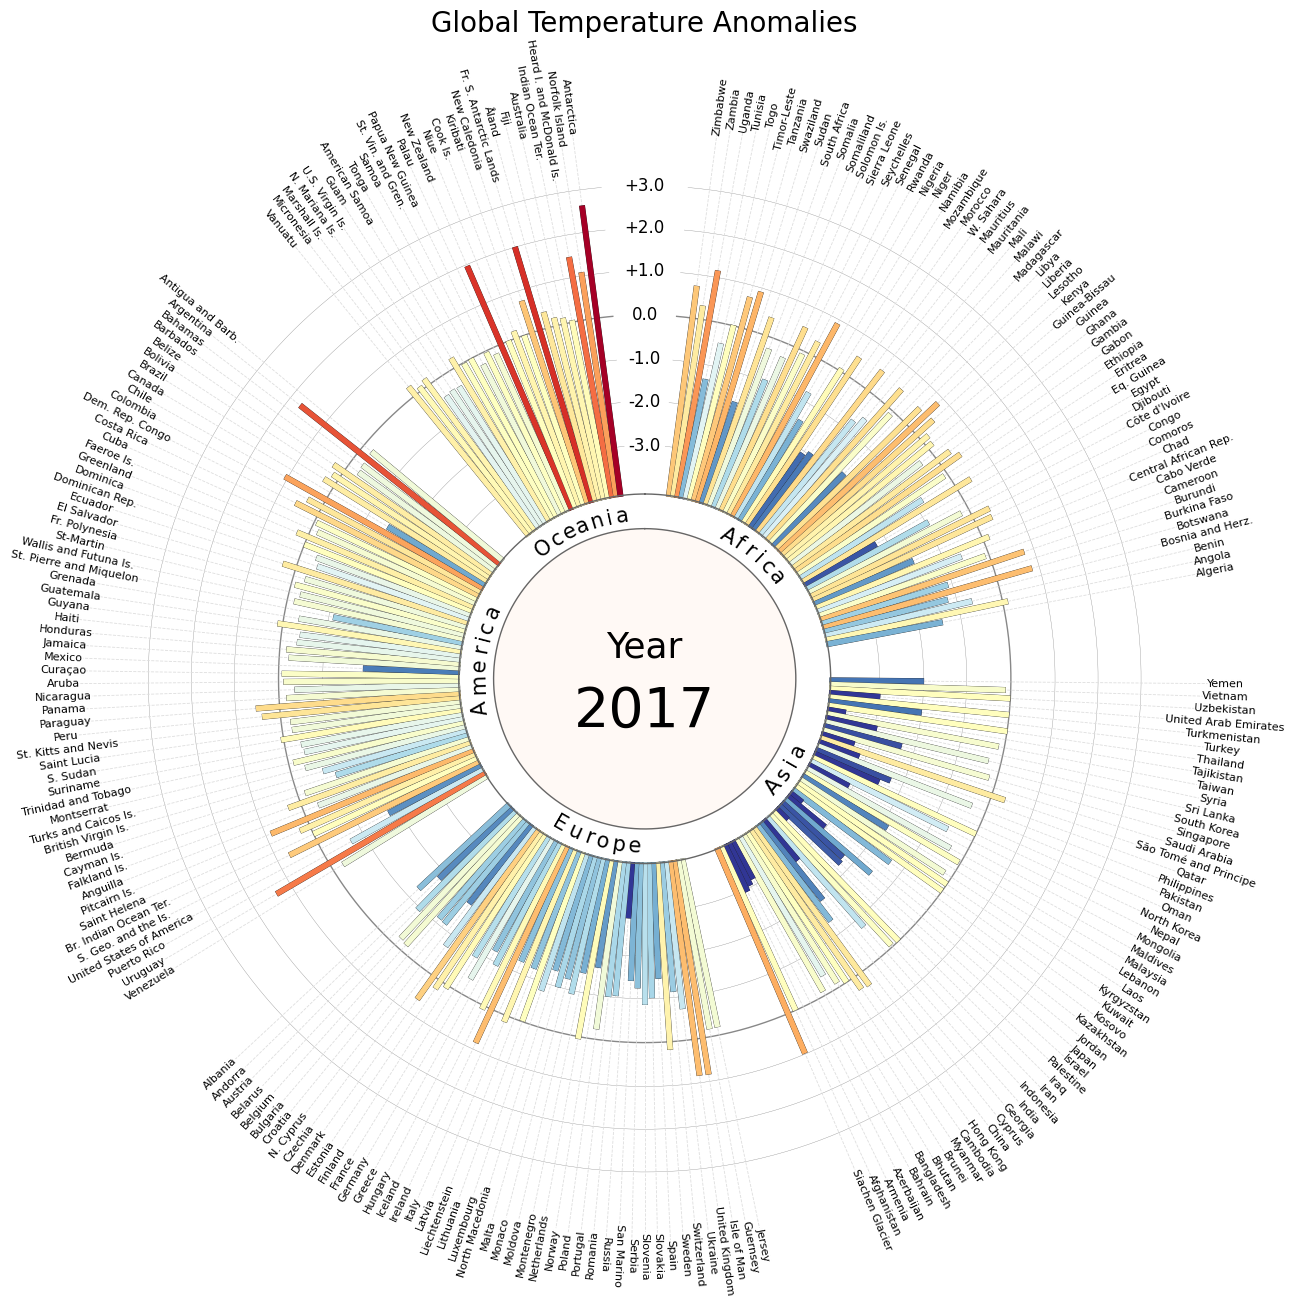

In [6]:
plot=plot_temperature_cirle(result,tmm='2017', figtim='Year', 
                            cmap='RdYlBu_r',vMin=-2.5,vMax=2.5)
plot.show()

***Loops the fuction through time to generate multiple fugure for animation***

In [7]:
output_directory = './plots' # make sure that the output directory exists
lon = tas.lon
lat = tas.lat
# for i in range(len(tas.time)):
for i in range(2): # sample times to loop
    
    dat = tas[i]
    time = np.datetime_as_string(tas['time'][i],  unit='D')[-5:] #gets date value without year 
    tm = f'{time}'
    
    result = categorize_countries_by_continents(dat, lon, lat, climatology)
    
    output_filename = os.path.join(output_directory, f'tempcircle{time}.png')
    
    plot=plot_temperature_cirle(result, tmm=tm, figtim='Date', cmap='RdYlBu_r',vMin=-3,vMax=3,optnm=output_filename)
    plot.close()
    print(f'plotted {tm}')
print('\n'.join(['.' for _ in range(10)]))

plotted 01-01
plotted 01-02
.
.
.
.
.
.
.
.
.
.
